# Quora Insincere Question Classification

### Kaggle Competition | 12/05/18

### Objective
To create a supervised learning model that is able to predict whether a question in Quora is sincere, or if it's a question founded upon false premises, or that intend to make a statement rather than ask a question.

### The code below allows for code in this notebook/kernel to be hidden

In [1]:
from IPython.display import HTML

HTML('''<script>code_show=true; function code_toggle() {if (code_show){$('div.input').hide();} else {$('div.input').show();}
 code_show = !code_show} $( document ).ready(code_toggle);</script>The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## 1. Import Libraries

In [2]:
# General
import warnings
from datetime import datetime
from datetime import timedelta
import os
import time
from tqdm import tqdm
import pickle

# Data Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Neural Networks
from keras.models import Model
from keras import Input, layers
from keras.layers import LSTM
from keras.layers import Embedding, Flatten, Dense, GRU, BatchNormalization, CuDNNLSTM, Bidirectional, Conv1D, MaxPooling1D, CuDNNGRU
from keras.layers import Reshape, Concatenate, Dropout, SpatialDropout1D, MaxPool1D
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback

# Random Forests
from sklearn.ensemble import RandomForestClassifier

# XGBoost
import xgboost as xg
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Text Processing
from keras import preprocessing
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Model Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score

#to show images within Jupyter Notebook without having to call "show()"
%matplotlib inline 


c:\users\dbejarano\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
c:\users\dbejarano\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## 2. Load and Observe Datasets

### 2.1 Load From Computer

In [3]:
# Load Datasets
train_df_original = pd.read_csv('train.csv')
test_df_original = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

### 2.2 Load From Kernel

In [4]:
# train_df_original = pd.read_csv("../input/train.csv")
# test_df_original = pd.read_csv("../input/test.csv")
# sample_submission = pd.read_csv("../input/sample_submission.csv")

In [5]:
# Make copies in case we want to go back to the original without having to load the datasets again
train_df = train_df_original.iloc[:10000].copy() 
test_df = test_df_original.iloc[:10000].copy() 

### 2.3 Display Datasets

In [6]:
display(train_df.head(3))
print('Training Set Size: ', train_df.shape)
display(test_df.head(3))
print('Test Set Size: ', test_df.shape)
display(sample_submission.head(3))

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0


Training Set Size:  (10000, 3)


,qid,question_text
0,00014894849d00ba98a9,My voice range is A2-C5. My chest voice goes u...
1,000156468431f09b3cae,How much does a tutor earn in Bangalore?
2,000227734433360e1aae,What are the best made pocket knives under $20...


Test Set Size:  (10000, 2)


,qid,prediction
0,00014894849d00ba98a9,0
1,000156468431f09b3cae,0
2,000227734433360e1aae,0


Each question in the training set is classified as 0=sincere or 1=insincere.

**What is considered "Insincere"?**

   -  Has a non-neutral tone
        - Has an exaggerated tone to underscore a point about a group of people
        - Is rhetorical and meant to imply a statement about a group of people
   -  Is disparaging or inflammatory
        - Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
        - Makes disparaging attacks/insults against a specific person or group of people
        - Based on an outlandish premise about a group of people
        - Disparages against a characteristic that is not fixable and not measurable
   -  Isn't grounded in reality
        - Based on false information, or contains absurd assumptions
    Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers

 ## 3. Exploratory Data Analysis (EDA)
This section explores characteristics of the data and extracts statistics that will inform our decision on which models to try and what results to expect.

### Target Distribution

([<matplotlib.axis.XTick at 0x16610940>,
 <a list of 2 Text xticklabel objects>)

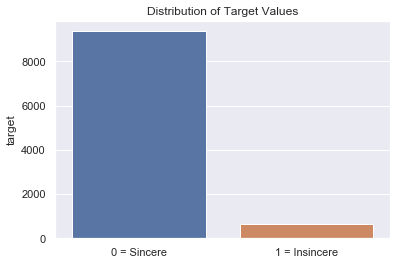

In [7]:
sns.set()
sns.barplot(train_df['target'].unique(), train_df['target'].value_counts())
plt.title('Distribution of Target Values')
plt.xticks(np.arange(2), ('0 = Sincere', '1 = Insincere'))

#### Analysis:
As one could expect, we have an imbalanced dataset where the great majority of the questions are sincere.

### Questions Length

By looking at the 5 longest questions, we realize that the longest one is 134 words long and seems to be an outlier. The next longest question is 66 words long, so we will remove the 134-long question to aid in our visualization of the dataset

#### Feature Engineering 1 - Remove question-length outlier

In [8]:
# Create new variable measuring the length of each question
train_df['question_length'] = train_df['question_text'].apply(lambda x: len(x.split()))

# Look at the 5 longest questions
train_df['question_length'].nlargest(5)
train_df = train_df[train_df['question_length']<120]

#### Plot Question Length Distributions

c:\users\dbejarano\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0.5,0,'Number of Words'),
 Text(0.5,1,'Distribution of Question Length by Target Group: Blue=Sincere | Orange=Insincere')]

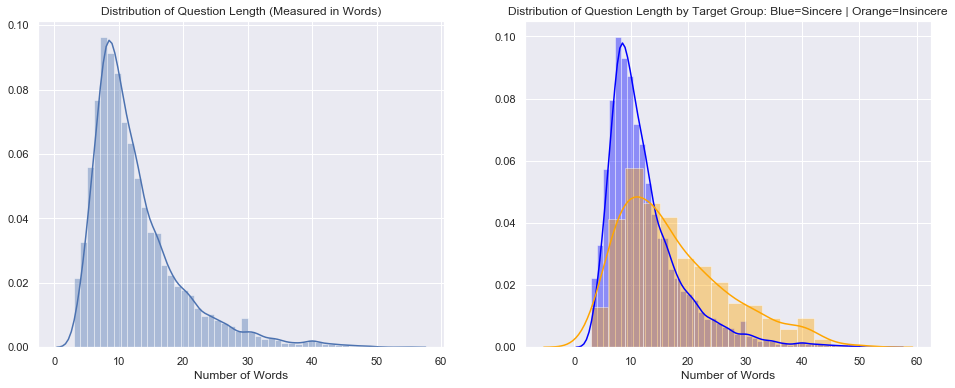

In [9]:
# Plot distribution of question lengths
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16, 6)
sns.distplot(train_df['question_length'], ax=axes[0])
axes[0].set(xlabel='Number of Words', title='Distribution of Question Length (Measured in Words)')
sns.distplot(train_df['question_length'][train_df['target']==0], ax=axes[1],color='blue')
sns.distplot(train_df['question_length'][train_df['target']==1], ax=axes[1],color='orange')
axes[1].set(xlabel='Number of Words', title='Distribution of Question Length by Target Group: Blue=Sincere | Orange=Insincere')

#### Analysis:
From the plot on the right we see that insincere questions have a distribution with a fatter tail, which shows that insincere questions tend to be longer.

### Most Frequent Words
Let's see if the distribution of most frequent words is different between sincere and insincere questions. The hypothesis is that it is.

#### Feature Engineering 2 - Remove Punctuation, Stop Words and Lemmatize

The following function removes punctuation, stop words and also lemmatizes the words on each of the questions in our training set.
The outcome is then joined so that our final result from this text_process function is a sentence, instead of a list of words. The main reason for doing this last step is so that we can directly feed the output into the functions that will vectorize our sentences, as they expect sentences and not list of words.

In [10]:
# Define function to process text
def text_process(mess):# mess stands for message
    '''
    1. Remove punctuation
    2. Remove Stop Words
    3. Return list of cleaned text words
    '''
    nopunc = [c for c in mess if c not in string.punctuation]
    nopunc = "".join(nopunc) # to join together separated characters back into words
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(w) for w in nopunc.split() if w.lower() not in stopwords.words('english')] # returns a list of list of words
    cleaned_sent = " ".join(lemmatized_words) # returns a list of sentences
    return(cleaned_sent)

The following code proceeds to clean the training data, separately for sincere and insincere questions.

In [11]:
start_time = time.time()

X_train_sincere = [text_process(mess) for mess in train_df['question_text'][train_df['target']==0]]
X_train_insincere = [text_process(mess) for mess in train_df['question_text'][train_df['target']==1]]
X_test = [text_process(mess) for mess in test_df['question_text']]

print('Number of Sincere Questions: ', len(X_train_sincere))
print('Number of Insincere Questions: ', len(X_train_insincere))

elapsed_time = time.time() - start_time
print("Elapsed Time: {}".format(elapsed_time))

Number of Sincere Questions:  9363
Number of Insincere Questions:  637
Elapsed Time: 191.5169539451599


#### Feature Engineering 3.A - Vectorize and Count using CountVectorizer

The function below is used to count the most frequent words for sincere and insincere questions in our training set.
The two plots below show the 15 most frequent words found on sincere and insincere questions, respectively. The x-axis shows the percentage of their occurrence compared to the total number of words in each category. To give an example, if the word "earphones" occurred 3 times in a mini dataset of 10 sentences, and each sentence happened to be 10 words long, then "earphones" would get a score of 0.03, or 3%.

In [12]:
# Define Vectorizer Function to Get Most Frequent Words
def vectorize_and_count(list_of_sentences):
    '''Takes a list of sentences (these should be cleaned/processed in advance) and returns:
    1. a list of words sorted by their frequency in the entire set of sentences
    2. all words in the vocabulary and their respective location in the bag_of_words vector
    3. the bag of words matrix'''
    vectorizer = CountVectorizer()
    vec_trial = vectorizer.fit(list_of_sentences)
    bow_trial = vec_trial.transform(list_of_sentences)

    sum_words = bow_trial.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec_trial.vocabulary_.items()]
    words_freq = sorted(words_freq, key= lambda x: x[1], reverse=True)
    return(words_freq, vec_trial, bow_trial)

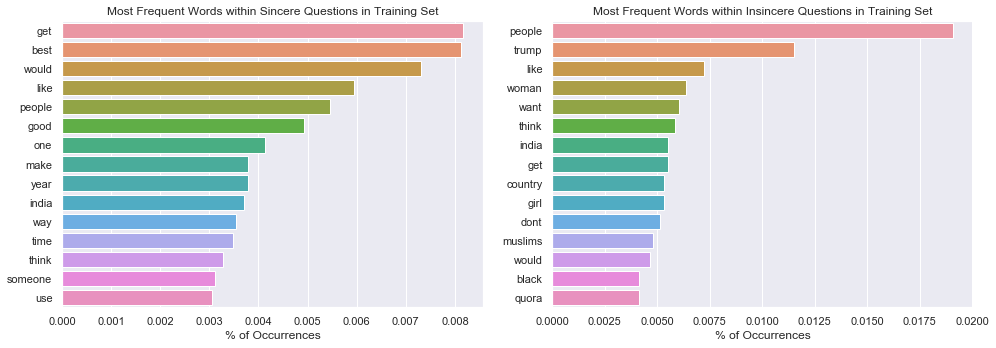

In [13]:
# Vectorize and Count 
sincere_frequent, sincere_vocab, sincere_bow = vectorize_and_count(X_train_sincere) 
insincere_frequent, insincere_vocab, insincere_bow = vectorize_and_count(X_train_insincere)

# Plot most frequent words for each target category
fig, axes = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(14, 5)
sns.barplot(y=np.array(sincere_frequent)[:15, 0], x=np.array(sincere_frequent)[:15, 1].astype(int)/np.sum(np.array(sincere_frequent)[:, 1].astype(int)), ax=axes[0])
axes[0].set(xlabel='% of Occurrences', title='Most Frequent Words within Sincere Questions in Training Set')
sns.barplot(y=np.array(insincere_frequent)[:15, 0], x=np.array(insincere_frequent)[:15, 1].astype(int)/np.sum(np.array(insincere_frequent)[:, 1].astype(int)), ax=axes[1])
axes[1].set(xlabel='% of Occurrences', title='Most Frequent Words within Insincere Questions in Training Set')
plt.tight_layout()

#### Analysis:
We can quickly learn that a good number of the most frequent insincere questions are related to controversial topics (from the perspective of contemporary public discourse). Here are some examples:
1. Trump is a political figure, and has been a controversial one.For or against, it's likely that questions involving him could be political and controversial.
2. It includes words like "white" and "black" which are probably used as adjectives in relation to a person's race. Those are probably questions with a tone of discrimination to them.
3. Muslims falls under a similar category as point #2.

#### Feature Engineering 3.B - Vectorize and Count w/ TF-IDF**

In [14]:
# Vectorize and count using TF-IDF
def get_tf_idf(list_of_sentences):
    '''Takes a list of sentences (these should be cleaned/processed in advance) and returns a list of 
    words sorted by their frequency in the entire set of sentences, as calculated by TF-IDF'''
    vectorizer = TfidfVectorizer()
    vec_trial = vectorizer.fit(list_of_sentences)
    bow_trial = vec_trial.transform(list_of_sentences)

    sum_words = bow_trial.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec_trial.vocabulary_.items()]
    words_freq = sorted(words_freq, key= lambda x: x[1], reverse=True)
    return(words_freq, vec_trial, bow_trial)

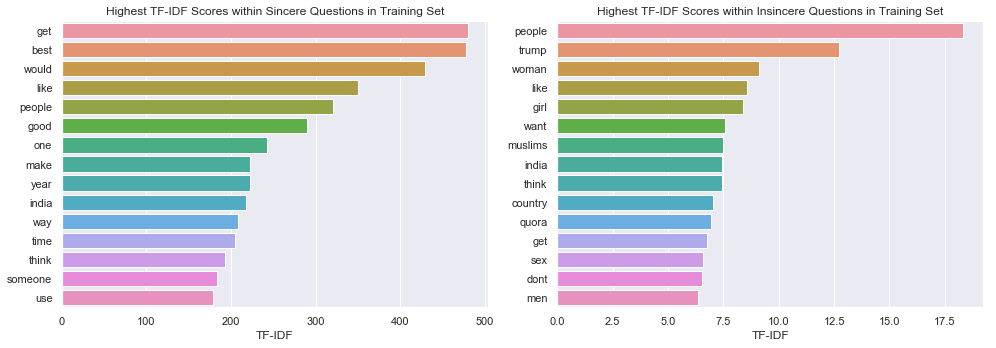

In [15]:
#Vectorize and Count 
sincere_freq_tfidf, sincere_vocab_tfidf, sincere_bow_tfidf = vectorize_and_count(X_train_sincere) 
insincere_freq_tfidf, insincere_vocab_tfidf, insincere_bow_tfidf = get_tf_idf(X_train_insincere)

# Plot most frequent words for each target category
fig, axes = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(14, 5)
sns.barplot(y=np.array(sincere_freq_tfidf)[:15, 0], x=np.array(sincere_freq_tfidf)[:15, 1].astype(float),ax=axes[0])
axes[0].set(xlabel='TF-IDF', title='Highest TF-IDF Scores within Sincere Questions in Training Set')
sns.barplot(y=np.array(insincere_freq_tfidf)[:15, 0], x=np.array(insincere_freq_tfidf)[:15, 1].astype(float), ax=axes[1])
axes[1].set(xlabel='TF-IDF', title='Highest TF-IDF Scores within Insincere Questions in Training Set')
plt.tight_layout()

#### Analysis:
Which is better for determining words relevance, their Frequency (CountVectorizer) or their Term Frequency Inverse-Document Frequency (TF-IDF)? Usually TF-IDF provides us with more information. While frequency is simply the count of occurrences of a particular word in the corpus, TF-IDF goes a step further. It's a multiplication of the frequency of word W in document D, by the log of the ratio of the total number of documents (in this case sentences) over the number of documents in the corpus that contain word W. Therefore, it incorporates the "importance" of the term in the corpus. 

## 4. Data Preprocessing

One of the key steps, which is to clean the data (remove punctuation, remove stop words,  and lemmatize) has already been performed. We have also already created word vectors to count the most frequent words on sincere and insincere questions. We will re-do this step though but this time we will re-vectorize the data without splitting it between sincere and insincere, that way we will get a joint vocabulary. If this seems like a unecessary repeated step, it's because it sort of is. There are two reasons for doing it here: 1) We performed the sincere vs insincere vectorization to see if frequent words varied between the two categories, and 2) Keras' Tokenizer (which will be the vectorizer we use next) facilitates padding. Padding allows us to get all obervations in the same size and be able to feed it into the model. Example: if Sentence A is 8 words long and Sentence B is 18 words long, we can set our maximum number of words to, say 14 (a compromise) and have padding add 6 zeros to A and remove 4 words from B. 

### Split into X and Y and shuffle
Since we cleaned the questions on sincere and insincere sets of data separately, below we combine and shuffle them randomly, as models can be biased if all instances of a category (particularly the target category) are shown in order. We make sure to shuffle y in the same way so that targets (0 or 1) still match their respective questions.

In [16]:
def regroup_train_data(sincere_list, insincere_list):
    '''Gets as input:
    1. Cleaned sincere list of questions
    2. Cleaned insincere list of questions
    Concatenates the two lists then it matches them with their corresponding label (sincere or insincere) and 
    shuffles the data. It returns a shuffled list of '''
    X = np.array(sincere_list + insincere_list) # both sincere and insincere have already been cleaned

    # Sort y_train so that it's in the same order as X_train: 0s first, then all 1s
    y_sincere = [0] * len(sincere_list)
    y_insincere = [1] * len(insincere_list)
    y = np.asarray(y_sincere + y_insincere)

    # Shuffle X_train and use the index to shuffle y_train accordingly
    indices = np.arange(X.shape[0])
    np.random.seed(1)
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    return(X, y)

X_train, y_train = regroup_train_data(X_train_sincere, X_train_insincere)

### Transform Sentences to Word Vectors
Models will need numerical representations of our observations. To convert our sentences into numerical representations, we will first create a word_index that contains all words in our dataset vocabulary, each one paired to an index. All sentences will be represented as an array of numbers, with numbers refering to the index for each word. 

Moreover, we will pad these word vectors so that all are of the same length.

Eventually, these word vectors will be converted to embeddings, so that we can represent relationships between words.

In [17]:
max_len = 65
max_words = 10000 # only the 40,000 most common words will be used

tokenizer = Tokenizer(num_words = max_words) 
tokenizer.fit_on_texts(X_train) # creates a list of tokens (words) of the 40000 most common words on "texts"
sequences = tokenizer.texts_to_sequences(X_train) # converts "texts" into sequences of tokens for the 10000 most common words
test_sequences = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index
X_padded = pad_sequences(sequences, maxlen=max_len)
y_array = np.asarray(y_train)
X_test = pad_sequences(test_sequences, maxlen=max_len)

### Split into Train and Validation Sets

In [18]:
training_samples = int(len(X_train)*0.8//1)
validation_samples = int(len(X_train)*0.2//1)

X_train = X_padded[:training_samples].copy()
X_val = X_padded[training_samples:].copy()
y_train = y_array[:training_samples].copy()
y_val = y_array[training_samples:].copy()

## 5. Trainig and Classification

### Model A: Very Basic TF-IDF Based Prediction
Just because you can make it complex, doesn't mean you should. In that spirit, the first approach will be a simple and somewhat naive model to predict based on a tf-idf-based score. Here's the methodology:

Each question will be assigned a score by multiplying each of its questions by the ranked index on the tf-idf score list, then divided by the number of words in the sentence. This will be performed for both the sincere and insincere questions tf-idf table. Each sentence will be assigned a category based on which tf-idf table produced the higher score.

For instance, the sentence "So many dogs" would first find the index of the word "so" in the sincere tf-idf score table. That table ranks words from highest to lowest tf-idf scores based on all sincere questions in our training set (it's represented as a graph at the beginning of this notebook). The same will be done for "many" and "dogs". Then, this process will be repeated for the insincere tf-idf table. Once that's done we will have two scores: one from the sincere tf-idf table and one from the insincere one. Basically, each sentence is being scored based on how high up each of its words rank on the tf-idf table. Words that are very relevant to sincere questoins will get higher scores. 

In [19]:
def get_tfidf_pred(df, cat1_tfidf, cat2_tfidf):
    '''Given an array of sentences (df), and two lists contining the tf-idf scores for
    our vocabulary of words, this function returns the category (0=sincere, 1=insincere)
    based on which of the tf-idf score datasets produced the highest sentence score.'''
    pred_tfidf = []
    for i in df:
        words = [list(word_index.keys())[list(word_index.values()).index(k)] for k in i if k!= 0]
        sen_len = np.count_nonzero(i)
        score_sincere = np.mean(np.sum([dict(cat1_tfidf)[w] if w in dict(cat1_tfidf)
                                        else 0 for w in words]))
        score_insincere = np.mean(np.sum([dict(cat2_tfidf)[w] if w in dict(cat2_tfidf)
                                        else 0 for w in words]))*20
        pred_tfidf.append(0 if score_sincere > score_insincere else 1)
    return(pred_tfidf)

In [20]:
pred_tfidf = get_tfidf_pred(X_val, sincere_freq_tfidf, insincere_freq_tfidf)

print('Classificatoin Report: ', '\n', classification_report(y_val, pred_tfidf))
conf_results = confusion_matrix(y_val, pred_tfidf)
print(conf_results)

Classificatoin Report:  
              precision    recall  f1-score   support

          0       0.97      0.91      0.94      1873
          1       0.31      0.62      0.41       127

avg / total       0.93      0.89      0.90      2000

[[1697  176]
 [  48   79]]


#### Analysis:

The basic model using only tf-idf scores to classify between sincere and insincere questions did not provide good results. Let's move on to more complex models also using the tf-idf vector representation of questions.

### Model B: Logistic Regression vs. Naive Bayes tf-idf Models
Here we will test whether Regression or Naive Bayes perform better on our data, both using the tf-idf vectors. Note that an important comparison would be to also train and predict analogous models but using the CountVectorizer function (which we used above), but here we will focus on tf-idf.

Unfortunately, since the purpose of this notebook is to tell a story of how the data is analyzed and trained on, the code below repeats some steps already performed. We are creating a new shuffled list of cleaned sentences and its corresponding labels. That is, we are using the data that was in between our tf-idf word score in the EDA section above and the tokenization step.

In [21]:
# Define directory path to save trained models to
dir_name = os.path.dirname(os.path.abspath("__file__"))

In [22]:
# np.concatenate((X_t_tf, X_v_tf), axis=0)

In [23]:
# Define Threshold ot Use for Both LogReg and NB Models
threshold = 0.30

# Get list of all questions already tokenized
X_for_tf, y_for_tf = regroup_train_data(X_train_sincere, X_train_insincere)
X_t_tf, X_v_tf, y_train_tf, y_val_tf = train_test_split(X_for_tf, y_for_tf, test_size=0.25)

# Fit TF-IDF to training data and transform data
tf_vect = TfidfVectorizer(# tokenizer=dummy_fun, preprocessor=dummy_fun,
                          min_df=3, max_features=None, strip_accents='unicode', analyzer='word',
                          ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1, stop_words='english')
tf_vect.fit(np.asarray(np.concatenate((X_t_tf, X_v_tf), axis=0)))
X_train_tf = tf_vect.transform(X_t_tf)
X_val_tf = tf_vect.transform(X_v_tf)

# Fit Logistic Regression Model and Predict
reg_model = LogisticRegression(C=1.0)
reg_model.fit(X_train_tf, y_train_tf)
pred_reg_proba = reg_model.predict_proba(X_val_tf)
pred_reg = (pred_reg_proba.T[1] >= threshold).astype(int)

# Evaluate Predictions
print('LOGISTIC REGRESSION')
print('Classification Report: ', '\n', classification_report(y_val_tf.astype(int), pred_reg))
conf_mat_reg = confusion_matrix(y_val_tf, pred_reg)
print("Confusion Matris: ", 'TN = {}'.format(conf_mat_reg[0][0]), 'FP = {}'.format(conf_mat_reg[0][1]))
print("                  ", 'FN = {}'.format(conf_mat_reg[1][0]), '  TP = {}'.format(conf_mat_reg[1][1]))

# Save Model
filename = 'reg_model.pk'
file_path = os.path.join(dir_name, filename)
with open(file_path, 'wb') as f:
    pickle.dump(reg_model, f)

# NAIVE BAYES
# Fitting a simple Naive Bayes on tf-idf
nb_model = MultinomialNB()
nb_model.fit(X_train_tf, y_train_tf)
pred_nb_proba = nb_model.predict_proba(X_val_tf)
pred_nb = (pred_nb_proba.T[1] >= threshold).astype(int)

# Evaluate Predictions
print('\nNAIVE BAYES')
print('Classification Report: ', '\n', classification_report(y_val_tf.astype(int), pred_nb))
conf_mat_nb = confusion_matrix(y_val_tf, pred_nb)
print("Confusion Matris: ", 'TN = {}'.format(conf_mat_nb[0][0]), 'FP = {}'.format(conf_mat_nb[0][1]))
print("                  ", 'FN = {}'.format(conf_mat_nb[1][0]), '  TP = {}'.format(conf_mat_nb[1][1]))

# Save Model
filename = 'nb_model.pk'
file_path = os.path.join(dir_name, filename)
with open(file_path, 'wb') as f:
    pickle.dump(nb_model, f)

LOGISTIC REGRESSION
Classification Report:  
              precision    recall  f1-score   support

          0       0.94      1.00      0.97      2324
          1       0.65      0.11      0.19       176

avg / total       0.92      0.93      0.91      2500

Confusion Matris:  TN = 2313 FP = 11
                   FN = 156   TP = 20

NAIVE BAYES
Classification Report:  
              precision    recall  f1-score   support

          0       0.93      1.00      0.96      2324
          1       0.70      0.04      0.08       176

avg / total       0.92      0.93      0.90      2500

Confusion Matris:  TN = 2321 FP = 3
                   FN = 169   TP = 7


### Model B:  Recurrent Neural Network w/ GRU and Training Embeddings

There are two main approaches to representing words in NLP problems. Both of them involve associating a vector with a token in the generated vocabulary. One way is to use one-hot-encoding where each word is represented as a vector the size of the vocabulary, with a one in the location of such word, and zeros everywhere else. The other is to use word embeddings, which are dense representations of words that we learn from data. They learn associations between words so that, to give a simple example, the word wolf is closer (in location and direction in the vector space) to the word dog compared to the word chair. 

There are two approaches to implementing word embeddings. The first one is to use already generated ones, like Glove or Word2Vec. These were trained on huge datasets and map the structure of the English language in a robust way. However, it has been shown empirically that embeddings are very specific to the application and context in hand. Unless your dataset is very small, the recommendation is to learn word embeddings on the dataset you are training your model on ,which is the other approach we will try (in this problem, we have over 1,000,000 samples which makes our dataset large enough for the model to learn useful word embeddings). We will first model a NN that learns its own embeddings and then will try giving pre-trained embeddings to the NN.

In [24]:
embed_size = 100

# Build Model
rnn_model = Sequential()
rnn_model.add(Embedding(max_words, embed_size, input_length=max_len))
rnn_model.add(Bidirectional(GRU(128, dropout=0.6, recurrent_dropout=0.7, return_sequences=True)))
rnn_model.add(Bidirectional(GRU(128, dropout=0.6, recurrent_dropout=0.7, return_sequences=True)))
rnn_model.add(Bidirectional(GRU(64)))
rnn_model.add(Dense(1, activation="sigmoid"))

# Compile and Fit Model
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history_rnn = rnn_model.fit(X_train, y_train, epochs=5, batch_size=256, validation_data=(X_val, y_val), verbose=1)

# Save Model
filename = 'rnn_model.pk'
file_path = os.path.join(dir_name, filename)
with open(file_path, 'wb') as f:
    pickle.dump(rnn_model, f)

Train on 8000 samples, validate on 2000 samples
Epoch 1/5
8000/8000 [==============================] - ETA: 7:40 - loss: 0.6966 - acc: 0.480 - ETA: 4:33 - loss: 0.6639 - acc: 0.709 - ETA: 3:28 - loss: 0.6291 - acc: 0.787 - ETA: 2:56 - loss: 0.5912 - acc: 0.831 - ETA: 2:35 - loss: 0.5519 - acc: 0.854 - ETA: 2:19 - loss: 0.5113 - acc: 0.869 - ETA: 2:06 - loss: 0.4667 - acc: 0.883 - ETA: 1:57 - loss: 0.4338 - acc: 0.891 - ETA: 1:49 - loss: 0.4109 - acc: 0.897 - ETA: 1:41 - loss: 0.4021 - acc: 0.900 - ETA: 1:34 - loss: 0.3968 - acc: 0.903 - ETA: 1:28 - loss: 0.3900 - acc: 0.906 - ETA: 1:23 - loss: 0.3754 - acc: 0.910 - ETA: 1:17 - loss: 0.3734 - acc: 0.911 - ETA: 1:12 - loss: 0.3643 - acc: 0.913 - ETA: 1:07 - loss: 0.3641 - acc: 0.913 - ETA: 1:02 - loss: 0.3582 - acc: 0.914 - ETA: 58s - loss: 0.3509 - acc: 0.916 - ETA: 53s - loss: 0.3487 - acc: 0.91 - ETA: 48s - loss: 0.3422 - acc: 0.91 - ETA: 44s - loss: 0.3370 - acc: 0.91 - ETA: 39s - loss: 0.3331 - acc: 0.91 - ETA: 35s - loss: 0.3290 - 

Classification Report:  
              precision    recall  f1-score   support

          0       0.96      0.97      0.96      1873
          1       0.40      0.34      0.37       127

avg / total       0.92      0.93      0.92      2000

TN = 1808 FP = 65
FN = 84 TP = 43


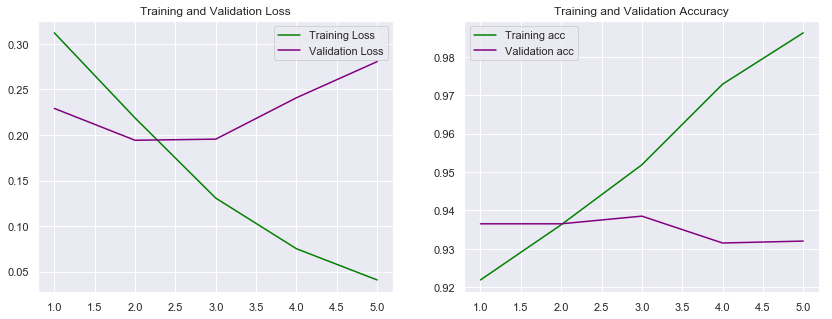

In [50]:
# Predict and Evaluate
pred_rnn_proba = rnn_model.predict(X_val)
threshold = 0.25
pred_rnn = (pred_rnn_proba >=threshold).astype(int)

print('Classification Report: ', '\n', classification_report(y_val, pred_rnn))
conf_mat = confusion_matrix(y_val, pred_rnn)
print('TN = {}'.format(conf_mat[0][0]), 'FP = {}'.format(conf_mat[0][1]))
print('FN = {}'.format(conf_mat[1][0]), 'TP = {}'.format(conf_mat[1][1]))

# Plot Training and Validation Losses and Accuracy Per Epoch
epochs = range(1, len(history_rnn.history['loss'])+1)
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(14, 5)
axes[0].plot(epochs, history_rnn.history['loss'], color='green', label='Training Loss')
axes[0].plot(epochs, history_rnn.history['val_loss'], color='purple', label='Validation Loss')
axes[0].set(title='Training and Validation Loss')
axes[0].legend()
axes[1].plot(epochs, history_rnn.history['acc'], color='green', label='Training acc')
axes[1].plot(epochs, history_rnn.history['val_acc'], color='purple', label='Validation acc')
axes[1].set(title='Training and Validation Accuracy')
axes[1].legend()

#### Analysis:

It starts to overfit very quickly (between 2 and 3 epochs). It would be a good idea to add dropout, reduce the complexity of the network, or use other regularization techniques...

### Model C - Convolutional Neural Networks (CNN) Training Embeddings
The second approach will be to use a series of 1D CNNs and MaxPoling layers to train our model. We will, again, be training our embeddings as part of our network.

In [26]:
filter_sizes = [1,2,3,4]
num_filters = 36

# Build Model
inp = Input(shape=(max_len, ))
x = Embedding(max_words, embed_size)(inp)
x = SpatialDropout1D(0.6)(x)

conv_0 = Conv1D(num_filters, kernel_size=(filter_sizes[1]),
                             kernel_initializer='he_normal', activation='elu')(x)
conv_1 = Conv1D(num_filters, kernel_size=(filter_sizes[1]),
                             kernel_initializer='he_normal', activation='elu')(x)
conv_2 = Conv1D(num_filters, kernel_size=(filter_sizes[3]), 
                             kernel_initializer='he_normal', activation='elu')(x)
conv_3 = Conv1D(num_filters, kernel_size=(filter_sizes[3]),
                             kernel_initializer='he_normal', activation='elu')(x)

mp_0 = MaxPool1D(pool_size=(max_len - filter_sizes[1] + 1))(conv_0)
mp_1 = MaxPool1D(pool_size=(max_len - filter_sizes[1] + 1))(conv_1)
mp_2 = MaxPool1D(pool_size=(max_len - filter_sizes[3] + 1))(conv_2)
mp_3 = MaxPool1D(pool_size=(max_len - filter_sizes[3] + 1))(conv_3)

conc = Concatenate(axis=1)([mp_0, mp_1, mp_2, mp_3])   
conc = Flatten()(conc)
conc = BatchNormalization()(conc)

out = Dense(1, activation="sigmoid")(conc)

cnn_model = Model(inputs=inp, outputs=out)

# Compile and Fit
cnn_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

cnn_history = cnn_model.fit(X_train, y_train, batch_size=512, epochs=10,
                 validation_data=(X_val, y_val), verbose=1)

cnn_model.summary()

# Save Model
filename = 'cnn_model.pk'
file_path = os.path.join(dir_name, filename)
with open(file_path, 'wb') as f:
    pickle.dump(cnn_model, f)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - ETA: 13:44 - loss: 0.9452 - acc: 0.49 - ETA: 12:29 - loss: 0.9192 - acc: 0.49 - ETA: 11:35 - loss: 0.9011 - acc: 0.49 - ETA: 10:33 - loss: 0.8856 - acc: 0.50 - ETA: 9:37 - loss: 0.8689 - acc: 0.5090 - ETA: 8:41 - loss: 0.8572 - acc: 0.511 - ETA: 7:47 - loss: 0.8505 - acc: 0.506 - ETA: 6:52 - loss: 0.8389 - acc: 0.509 - ETA: 5:57 - loss: 0.8303 - acc: 0.509 - ETA: 5:02 - loss: 0.8225 - acc: 0.513 - ETA: 4:08 - loss: 0.8159 - acc: 0.515 - ETA: 3:14 - loss: 0.8086 - acc: 0.518 - ETA: 2:20 - loss: 0.8018 - acc: 0.521 - ETA: 1:27 - loss: 0.7947 - acc: 0.525 - ETA: 33s - loss: 0.7868 - acc: 0.529 - 838s 105ms/step - loss: 0.7825 - acc: 0.5319 - val_loss: 0.8983 - val_acc: 0.2700
Epoch 2/10
8000/8000 [==============================] - ETA: 12:57 - loss: 0.6518 - acc: 0.60 - ETA: 12:05 - loss: 0.6524 - acc: 0.61 - ETA: 11:13 - loss: 0.6533 - acc: 0.61 - ETA: 10:22 - loss: 0.6449 - acc: 0.62 

spatial_dropout1d_1 (SpatialDro (None, 65, 100)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 64, 36)       7236        spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 64, 36)       7236        spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 62, 36)       14436       spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 62, 36)       14436       spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
max_poolin

Classification Report:  
              precision    recall  f1-score   support

          0       0.94      1.00      0.97      1873
          1       0.00      0.00      0.00       127

avg / total       0.88      0.94      0.91      2000

TN = 1872 FP = 1
FN = 127 TP = 0


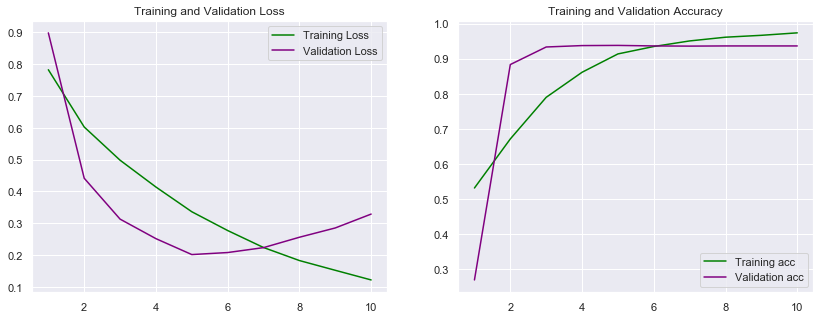

In [27]:
# Predict and Evaluate
pred_cnn_proba = cnn_model.predict(X_val)
threshold = 0.3
pred_cnn = (pred_cnn_proba >=threshold).astype(int)

print('Classification Report: ', '\n', classification_report(y_val, pred_cnn))
conf_mat = confusion_matrix(y_val, pred_cnn)
print('TN = {}'.format(conf_mat[0][0]), 'FP = {}'.format(conf_mat[0][1]))
print('FN = {}'.format(conf_mat[1][0]), 'TP = {}'.format(conf_mat[1][1]))

# Plot Training and Validation Losses and Accuracy Per Epoch
epochs = range(1, len(cnn_history.history['loss'])+1)
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(14, 5)
axes[0].plot(epochs, cnn_history.history['loss'], color='green', label='Training Loss')
axes[0].plot(epochs, cnn_history.history['val_loss'], color='purple', label='Validation Loss')
axes[0].set(title='Training and Validation Loss')
axes[0].legend()
axes[1].plot(epochs, cnn_history.history['acc'], color='green', label='Training acc')
axes[1].plot(epochs, cnn_history.history['val_acc'], color='purple', label='Validation acc')
axes[1].set(title='Training and Validation Accuracy')
axes[1].legend()

### MODEL D: Best Model + Pre-trained Embeddings (GloVe)
As discussed above, we can utilize pre-trained embeddings as input into our model. Here we will use GloVe, but other great options are word2vec and fastText.

#### Step 1 - Load Embeddings from File

We will be using 100-dimensional embeddings. The model would perform better with the 300-dimensional version GloVe offers, but that would take longer to train, so we'll go with 100.

In [28]:
# Load Embeddings File From Computer
glove_dir = r'C:\Users\dbejarano\Dropbox\Data Analytics Projects\03 Pre-Trained Basis'

this_dir = os.path.dirname(os.path.abspath('__file__'))
glove_file_path = os.path.join(glove_dir, 'glove.6B.100d.txt')

# # Load Embeddings File From Kernel
# f = open('../input/embeddings/glove.840B.300d/glove.840B.300d.txt')
# f = open('../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt')

#### Step 2 - Create Embeddings Matrix
The way Keras feeds embeddings into the model is as follows: padded sentences (which we already have) are provided as input. Each word is associated to its embedding via an embedding matrix. This matrix must be organized in the same order as our vocabulary per the word_index generated with Tokenizer. This way,the word number, say 273, can be matched with the embedding at location 273, which will correspond to the word that 273 is associated with in our word_index.

In [29]:
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(glove_file_path, encoding="utf8"))

nb_words = min(max_words, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_words: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i-1] = embedding_vector

#### Step 3 - Build Model

In [31]:
filter_sizes = [1,2,3,4]
num_filters = 36

# Build Model
inp = Input(shape=(max_len, ))
x = Embedding(max_words, embed_size, weights=[embedding_matrix])(inp)
x = SpatialDropout1D(0.6)(x)

conv_0 = Conv1D(num_filters, kernel_size=(filter_sizes[1]),
                             kernel_initializer='he_normal', activation='elu')(x)
conv_1 = Conv1D(num_filters, kernel_size=(filter_sizes[1]),
                             kernel_initializer='he_normal', activation='elu')(x)
conv_2 = Conv1D(num_filters, kernel_size=(filter_sizes[3]), 
                             kernel_initializer='he_normal', activation='elu')(x)
conv_3 = Conv1D(num_filters, kernel_size=(filter_sizes[3]),
                             kernel_initializer='he_normal', activation='elu')(x)

mp_0 = MaxPool1D(pool_size=(max_len - filter_sizes[1] + 1))(conv_0)
mp_1 = MaxPool1D(pool_size=(max_len - filter_sizes[1] + 1))(conv_1)
mp_2 = MaxPool1D(pool_size=(max_len - filter_sizes[3] + 1))(conv_2)
mp_3 = MaxPool1D(pool_size=(max_len - filter_sizes[3] + 1))(conv_3)

conc = Concatenate(axis=1)([mp_0, mp_1, mp_2, mp_3])   
conc = Flatten()(conc)
conc = BatchNormalization()(conc)

out = Dense(1, activation="sigmoid")(conc)

cnn_model2 = Model(inputs=inp, outputs=out)

# Compile and Fit
cnn_model2.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

cnn_hist2 = cnn_model2.fit(X_train, y_train, batch_size=512, epochs=5,
                 validation_data=(X_val, y_val), verbose=1)

cnn_model2.summary()

# Save Model
filename = 'cnn2_model.pk'
file_path = os.path.join(dir_name, filename)
with open(file_path, 'wb') as f:
    pickle.dump(cnn_model2, f)

2000/2000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s 2ms/step


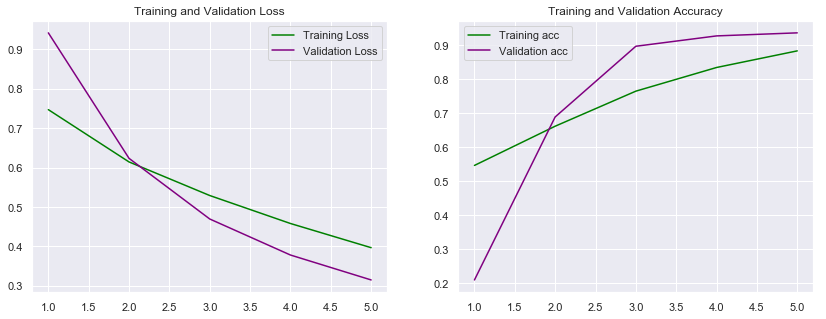

In [47]:
# Predict and Evaluate
pred_cnn2_proba = cnn_model2.predict(X_val, verbose=1)
threshold = 0.3
pred_cnn2 = (pred_cnn2_proba >=threshold).astype(int)

# Plot Training and Validation Losses and Accuracy Per Epoch
epochs = range(1, len(cnn_hist2.history['loss'])+1)
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(14, 5)
axes[0].plot(epochs, cnn_hist2.history['loss'], color='green', label='Training Loss')
axes[0].plot(epochs, cnn_hist2.history['val_loss'], color='purple', label='Validation Loss')
axes[0].set(title='Training and Validation Loss')
axes[0].legend()
axes[1].plot(epochs, cnn_hist2.history['acc'], color='green', label='Training acc')
axes[1].plot(epochs, cnn_hist2.history['val_acc'], color='purple', label='Validation acc')
axes[1].set(title='Training and Validation Accuracy')
axes[1].legend()

In [48]:
# Reports
print('Classification Report: ', '\n', classification_report(y_val, pred_cnn2))
conf_mat = confusion_matrix(y_val, pred_cnn2)
print('TN = {}'.format(conf_mat[0][0]), 'FN = {}'.format(conf_mat[1][0]))
print('FP = {}'.format(conf_mat[0][1]), 'TP = {}'.format(conf_mat[1][1]))

Classification Report:  
              precision    recall  f1-score   support

          0       0.95      0.89      0.92      1873
          1       0.16      0.31      0.21       127

avg / total       0.90      0.85      0.87      2000

TN = 1658 FN = 87
FP = 215 TP = 40


#### Analysis:

The results from our model are promising. We got an f1-score of 0.91. However, we can observe that the performance on predicting the positive class is low at a 0.21 f1-score.

How could this model be improved further? First, notice that at 5 epochs the validation and training loss are still decreasing. In practice, you would run the model for as many epochs needed for the model to start overfitting, then go back to the simplest model (prior to overfitting) with a low enough error. Here we stopped at 5 because of the added computational time that comes with more epochs. Also, note that it's unusual for the validation loss to be lower than the training loss, and when we run the model for more epochs we see this trend reverses (not shown here). 

Second, as previously discussed we only used 10,000 questions (data points) to train our model, but we have over 1,000,000 at our dispossal. Again the reason is because this was ran on a CPU with limited computer power, so it would've taken days to trian on 1,000,000 observations. The model is practically guaranteed to performed better ("how much" is more of an empirical question) by training on 100x more samples though.

### Save and Export File

For the purposes of this notebook that is the end of the analysis. However, when submitting this to Kaggle we obviously need to make predictions on the test set and upload that file.

In [ ]:
# test_pred = np.round(np.argmax(test_pred, axis=1)).astype(int)
# sub = sample_submission.copy()
# sub['prediction'] = test_pred
# sub.to_csv("submission.csv", index=False)

### Additional Work

There are other things that could have been tried to improve the model.
One of them is to use over-sampling to produce additional synthetic insincere questions. It's basically SMOTE for text. To accomplish this, a possible approach would be to average embeddings across insincere questions, and make that average a new observation.

Another thing to try would be to incorporate the length of the sentence into the model. We saw in the EDA that sincere and insincere questions have different length distributions, with insincere questions usually being longer. An option would be to add a vector to arrays that represent sentences as matrices of embedding vectors. That vector would contain the length of the sentence. 